In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Using SkLearn

In [5]:
y_true = [1,0,1,1,0,1,0]
y_pred = [1,0,1,0,0,1,1]

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred)
precision2 = precision_score(y_true, y_pred, average='macro')

recall = recall_score(y_true, y_pred)
recall2 = recall_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.3f}")

print(f"Prediction: {precision:.3f}")
print(f"Prediction2: {precision2:.3f}")

print(f"Recall: {recall:.3f}")
print(f"Recall2: {recall2:.3f}")


Accuracy: 0.714
Prediction: 0.750
Prediction2: 0.708
Recall: 0.750
Recall2: 0.708


'macro' → averages each class’s precision/recall equally.

'micro' → computes global TP/FP/FN (good when classes are imbalanced).

'weighted' → like macro but weighted by class frequency.

# Implementing from scratch

In [6]:
import numpy as np

x = np.array([1,0,0,1,1,0,0])
y = np.array([1,1,0,0,0,0,0])


# "AND" is invalid since it tries to evaluate
#for entire array and here its ambiguous, use elementwise logical "&""

tp = np.sum((y_pred==1) & (y_true==1))
tn = np.sum((y_pred==0) & (y_true==0))
fp = np.sum((y_pred==1) & (y_true==0))
fn = np.sum((y_pred==0) & (y_true==1))

accuracy = (tp+tn) / (tp+tn+fp+fn)
precision = (tp) / (tp+fp) if (tp+fp)!=0 else 0
recall = (tp) / (tp+fn) if (tp+fn)!=0 else 0

print(f"Accuracy: {accuracy:.3f}")
print(f"Prediction: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Accuracy: nan
Prediction: 0.000
Recall: 0.000


/tmp/ipython-input-905231189.py:15: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = (tp+tn) / (tp+tn+fp+fn)


### 🔍 Accuracy, Precision, Recall, and F1 — Intuition & Use

#### **1. Accuracy**
- **Formula:**  
  $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$ <br>
- **Meaning:** Overall correctness — how many predictions were right out of all.  
- **Good for:** Balanced datasets (equal positives & negatives are equally important).  
- **Limitation:** Misleading if data is imbalanced (e.g., 99% negatives).  

---

#### **2. Precision**
- **Formula:**  
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  <br>
- **Meaning:** Of all predicted positives, how many were actually correct.  
- **Intuition:** “How *precise* are my positive predictions?”  
- **Use when:** False positives are costly (e.g., predicting disease, spam detection).  

---

#### **3. Recall (Sensitivity)**
- **Formula:**  
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  <br>
- **Meaning:** Of all actual positives, how many did we catch?
- **Intuition:** “How *complete* is my detection?”  
- **Use when:** Missing positives is costly (e.g., detecting cancer, fraud detection).  

---

#### **4. F1 Score**
- **Formula:**  
  $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  <br>
- **Why Harmonic Mean:**  
  - Penalizes imbalance — high only if both precision and recall are high.  
  - Arithmetic mean would ignore that imbalance.  
  - Harmonic mean emphasizes the smaller value.  

---

#### ✅ **When to Use**
| Metric     | Use Case Example                  | Priority                     |
|-------------|-----------------------------------|-------------------------------|
| Accuracy    | Balanced dataset                  | General correctness           |
| Precision   | Spam filter, medical diagnosis     | Avoid false alarms            |
| Recall      | Fraud or cancer detection          | Don’t miss real cases         |
| F1 Score    | When both matter, imbalanced data  | Balance between the two       |


In [ ]:
!pip install torchmetrics

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

import torch
from torchmetrics.classification import BinaryAccuracy

# Toy MNIST application of Accuracy, Precision, Recall

In [10]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Data

tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_ds = datasets.MNIST(root='./data', train=True,  download=True, transform=tfm)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 638kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]


In [12]:
# Model: 784 → 256 → 10

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits

In [13]:
# Training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


model.train()
for epoch in range(3):
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward(); opt.step()
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch+1}: train loss={loss_sum/total:.4f}, acc={correct/total:.4f}")

Epoch 1: train loss=0.2634, acc=0.9232
Epoch 2: train loss=0.1056, acc=0.9682
Epoch 3: train loss=0.0713, acc=0.9780


In [14]:
# Evaluate

model.eval()
num_classes = 10
conf = torch.zeros((num_classes, num_classes), dtype=torch.long)  # [true, pred]

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x).argmax(1).cpu()
        for t, p in zip(y, pred):
            conf[t, p] += 1

print("Confusion matrix (rows=true, cols=pred):\n", conf)

Confusion matrix (rows=true, cols=pred):
 tensor([[ 967,    0,    1,    1,    0,    0,    6,    0,    4,    1],
        [   0, 1126,    2,    1,    0,    1,    2,    0,    3,    0],
        [   4,    4,  994,    5,    3,    0,    3,    9,   10,    0],
        [   0,    0,    1,  995,    0,    2,    0,    6,    3,    3],
        [   2,    0,    3,    1,  957,    0,    4,    3,    1,   11],
        [   2,    0,    0,   12,    2,  863,    6,    0,    5,    2],
        [   5,    3,    1,    1,    1,    2,  941,    0,    4,    0],
        [   1,    8,    6,    4,    0,    0,    0,  998,    0,   11],
        [   5,    0,    2,   10,    1,    2,    3,    3,  944,    4],
        [   2,    4,    0,    6,    7,    2,    0,    6,    2,  980]])


In [15]:
# Accuracy, Precision, Recall from Scratch

accuracy = conf.trace().item() / conf.sum().item()

eps = 1e-12  # avoid div-by-zero

TP = conf.diag()
FP = conf.sum(0) - TP
FN = conf.sum(1) - TP


# Per-class Precision_i = TP_i / (TP_i + FP_i)
precision_per_class = (TP.float() / (TP + FP + eps).float()).tolist()

# Per-class Recall_i    = TP_i / (TP_i + FN_i)
recall_per_class    = (TP.float() / (TP + FN + eps).float()).tolist()

# Macro (unweighted mean across classes)
macro_precision = sum(precision_per_class) / num_classes
macro_recall    = sum(recall_per_class) / num_classes

# Micro (global TP/FP/FN across all classes ≡ accuracy for single-label)
micro_precision = conf.trace().item() / conf.sum(0).sum().item()
micro_recall    = conf.trace().item() / conf.sum(1).sum().item()

print(f"\nAccuracy (micro): {accuracy:.4f}")
print(f"Macro Precision : {macro_precision:.4f}")
print(f"Macro Recall    : {macro_recall:.4f}")
print(f"Micro Precision : {micro_precision:.4f}")
print(f"Micro Recall    : {micro_recall:.4f}")


Accuracy (micro): 0.9765
Macro Precision : 0.9766
Macro Recall    : 0.9763
Micro Precision : 0.9765
Micro Recall    : 0.9765


In [16]:
# per-class metrics
for c in range(num_classes):
    print(f"Class {c}: Precision={precision_per_class[c]:.4f}, Recall={recall_per_class[c]:.4f}")

Class 0: Precision=0.9787, Recall=0.9867
Class 1: Precision=0.9834, Recall=0.9921
Class 2: Precision=0.9842, Recall=0.9632
Class 3: Precision=0.9604, Recall=0.9851
Class 4: Precision=0.9856, Recall=0.9745
Class 5: Precision=0.9897, Recall=0.9675
Class 6: Precision=0.9751, Recall=0.9823
Class 7: Precision=0.9737, Recall=0.9708
Class 8: Precision=0.9672, Recall=0.9692
Class 9: Precision=0.9684, Recall=0.9713


# ⚙️ F1, ROC, AUC

### **F1 Score**
- **What:** Balances precision and recall into one metric.  
- **Formula:**  
  $$F1 = 2 \cdot \frac{P \cdot R}{P + R}$$  
  where  
  $$P = \frac{TP}{TP + FP}, \quad R = \frac{TP}{TP + FN}$$  
- **Why Harmonic Mean:**  
  - Ensures both precision and recall are high.  
  - Arithmetic mean would overvalue one if the other is low.  
  - Harmonic mean emphasizes the smaller value, punishing imbalance.  

---

### **ROC Curve**
- **What:** Shows tradeoff between true positive rate and false positive rate as the classification threshold changes.  
- **Axes:**  
  - **x = FPR (False Positive Rate)**  
    $$\text{FPR} = \frac{FP}{FP + TN}$$  
    → Fraction of actual negatives incorrectly classified as positives.  
  - **y = TPR (True Positive Rate)**  
    $$\text{TPR} = \frac{TP}{TP + FN}$$  
    → Fraction of actual positives correctly identified (a.k.a. Recall / Sensitivity).  
- **How:** Sweep threshold from \( +\infty \) → \( -\infty \) on predicted **scores/probabilities**, computing (FPR, TPR) pairs.  

---

### **AUC (Area Under the ROC Curve)**
- **What:** Measures the model’s ability to rank positives higher than negatives.  
- **Interpretation:**  
  - \( \text{AUC} = 1.0 \): Perfect model  
  - \( \text{AUC} = 0.5 \): Random guessing  
- **How:** Computed as the numeric integral of the ROC curve (e.g., trapezoidal rule).  
- **Intuition:** Higher AUC = better separability between classes.  

---

#### ✅ **When to Use What**
| Metric  | Best Used When | Focus |
|----------|----------------|--------|
| **F1** | Imbalanced data where both precision & recall matter | Single threshold |
| **ROC / AUC** | Comparing models independent of threshold | Global ranking ability |
| **PR-AUC** | Very rare positives (e.g., fraud, disease) | Focus on positives only |


In [17]:
import numpy as np
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc

# Binary example
y_true  = np.array([0,1,1,0,1,0,1,0,0,1])
y_score = np.array([0.05,0.90,0.80,0.20,0.65,0.10,0.73,0.40,0.30,0.95])
y_pred  = (y_score >= 0.5).astype(int)

In [18]:
# F1
f1 = f1_score(y_true, y_pred)

# ROC (FPR/TPR at all thresholds)
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# AUC
auc_trapz = auc(fpr, tpr)                 # trapezoid on (fpr,tpr)
auc_direct = roc_auc_score(y_true, y_score)  # convenience

print(f"F1: {f1:.3f}")
print(f"AUC (trapz): {auc_trapz:.3f}, AUC (direct): {auc_direct:.3f}")
# fpr,tpr,thresholds give you the full ROC curve if you want to plot later


F1: 1.000
AUC (trapz): 1.000, AUC (direct): 1.000


In [19]:
# --- F1 from TP/FP/FN ---

TP = np.sum((y_true==1) & (y_pred==1))
FP = np.sum((y_true==0) & (y_pred==1))
FN = np.sum((y_true==1) & (y_pred==0))

precision = TP / (TP + FP + 1e-12)
recall    = TP / (TP + FN + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)

print(f"F1 (manual): {f1:.3f}")

# --- ROC points by sweeping thresholds ---
# thresholds: +inf, then unique scores descending (each step lowers the bar)
uniq = np.unique(y_score)[::-1]
thresholds = np.r_[np.inf, uniq]

P = np.sum(y_true==1)
N = np.sum(y_true==0)

tpr_list, fpr_list = [], []
for thr in thresholds:
    y_hat = (y_score >= thr).astype(int)
    TP = np.sum((y_true==1) & (y_hat==1))
    FP = np.sum((y_true==0) & (y_hat==1))
    TPR = TP / (P + 1e-12)         # recall/sensitivity
    FPR = FP / (N + 1e-12)
    tpr_list.append(TPR)
    fpr_list.append(FPR)

tpr = np.array(tpr_list)
fpr = np.array(fpr_list)

# --- AUC via trapezoidal rule over (fpr,tpr) ---
# Ensure fpr is non-decreasing; thresholds constructed above already ensure that.
auc_trapz = np.trapz(tpr, fpr)
print(f"AUC (manual trapz): {auc_trapz:.3f}")


F1 (manual): 1.000
AUC (manual trapz): 1.000


/tmp/ipython-input-1102865225.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_trapz = np.trapz(tpr, fpr)


# Effect of using AM and GM instead of GM in F1 score calculation

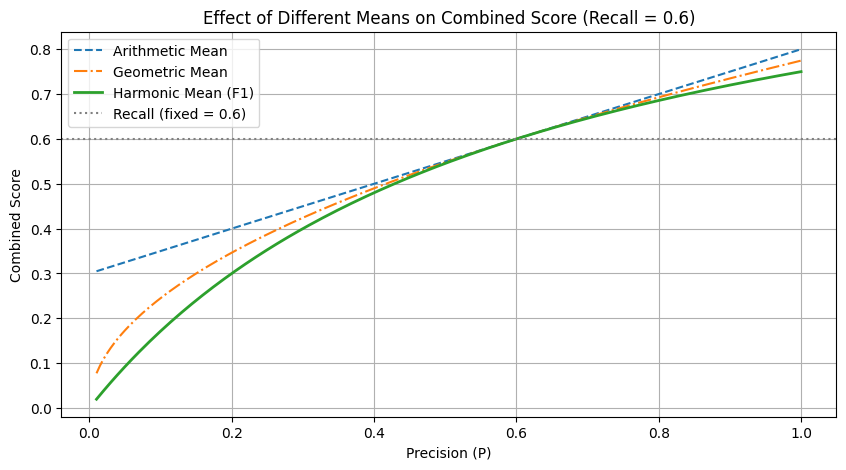

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Fix Recall and vary Precision
R = 0.6                               # fixed recall
P = np.linspace(0.01, 1, 200)         # precision range

# Calculate three means
AM = (P + R) / 2                      # Arithmetic Mean
GM = np.sqrt(P * R)                   # Geometric Mean
HM = 2 * P * R / (P + R)              # Harmonic Mean (F1)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(P, AM, label='Arithmetic Mean', linestyle='--')
plt.plot(P, GM, label='Geometric Mean', linestyle='-.')
plt.plot(P, HM, label='Harmonic Mean (F1)', linewidth=2)
plt.axhline(R, color='gray', linestyle=':', label='Recall (fixed = 0.6)')
plt.xlabel("Precision (P)")
plt.ylabel("Combined Score")
plt.title("Effect of Different Means on Combined Score (Recall = 0.6)")
plt.legend()
plt.grid(True)
plt.show()


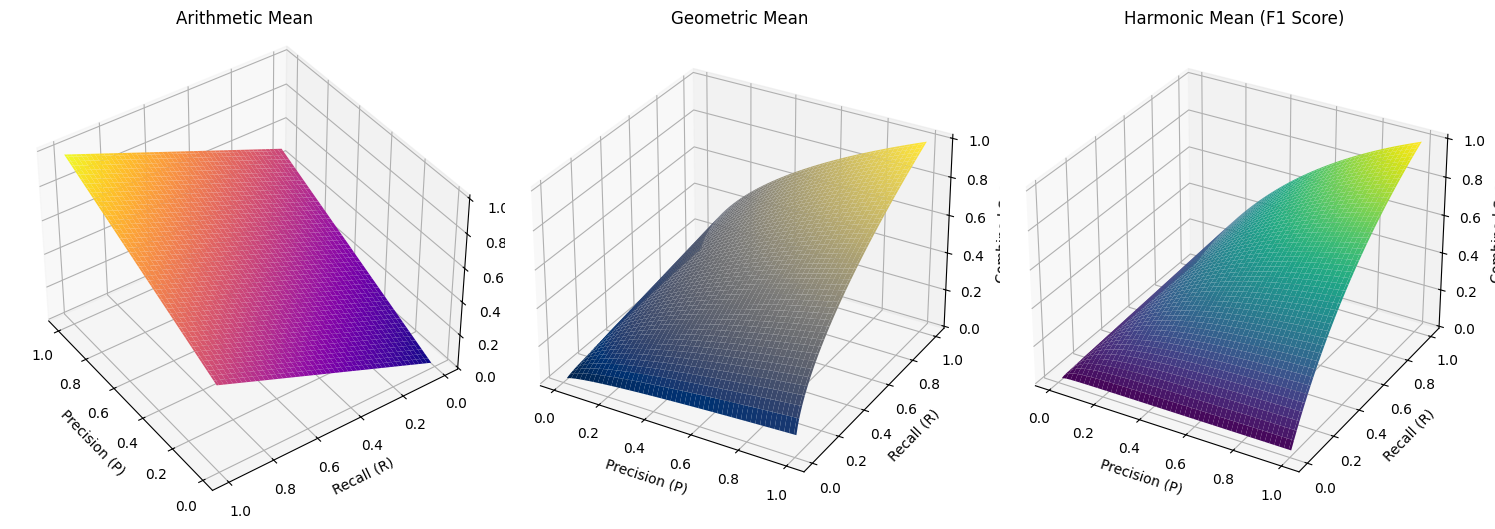

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Precision & Recall range
P = np.linspace(0.01, 1, 100)
R = np.linspace(0.01, 1, 100)
P, R = np.meshgrid(P, R)

# Calculate means
AM = (P + R) / 2
GM = np.sqrt(P * R)
HM = 2 * P * R / (P + R)   # Harmonic Mean (F1)

# Create subplots
fig = plt.figure(figsize=(15, 5))

# Arithmetic Mean
ax1 = fig.add_subplot(131, projection='3d')
ax1.view_init(elev=40, azim=145)
ax1.plot_surface(P, R, AM, cmap='plasma')
ax1.set_title('Arithmetic Mean')
ax1.set_xlabel('Precision (P)')
ax1.set_ylabel('Recall (R)')
ax1.set_zlabel('Combined Score')

# Geometric Mean
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(P, R, GM, cmap='cividis')
ax2.set_title('Geometric Mean')
ax2.set_xlabel('Precision (P)')
ax2.set_ylabel('Recall (R)')
ax2.set_zlabel('Combined Score')

# Harmonic Mean (F1)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(P, R, HM, cmap='viridis')
ax3.set_title('Harmonic Mean (F1 Score)')
ax3.set_xlabel('Precision (P)')
ax3.set_ylabel('Recall (R)')
ax3.set_zlabel('Combined Score')

plt.tight_layout()
plt.show()


## 🎯 Why F1 Uses the Harmonic Mean

### 🧩 1️⃣ What Precision and Recall Represent
Precision (**P**) and Recall (**R**) are *rates*:

$$
P = \frac{TP}{TP + FP}, \quad R = \frac{TP}{TP + FN}
$$

Both share the same numerator (**TP**) but have different denominators.  
They describe how well the model captures *true positives* from two different perspectives — thus, both are **reciprocal-type measures**.

---

### ⚖️ 2️⃣ Why We Need a “Balanced” Average
We need a single score that:
1. Increases when both P and R increase.  
2. Is **symmetric** (swapping P and R doesn’t change the result).  
3. Drops sharply when either P or R is low.

This ensures the model is rewarded only when **both** precision and recall are high.

---

### 🧠 3️⃣ Why the Harmonic Mean Arises Naturally
When averaging *rates with a shared numerator*, the correct mathematical mean is **harmonic**, not arithmetic or geometric.

Example analogy — average speed:  
If you drive the same distance \( d \) at speeds \( v_1 \) and \( v_2 \):

$$
v_{\text{avg}} = \frac{2}{\frac{1}{v_1} + \frac{1}{v_2}}
$$

Because total time adds reciprocally, the harmonic mean gives the correct effective rate.

Similarly, for precision and recall:

$$
F_1 = \frac{2PR}{P + R} = \frac{2}{\frac{1}{P} + \frac{1}{R}}
$$

This behaves as the **effective rate** when both precision and recall must jointly succeed.

---

### 📐 4️⃣ Algebraic View
Substituting \( P, R \) in terms of counts:

$$
P = \frac{TP}{TP + FP}, \quad R = \frac{TP}{TP + FN}
$$

we get:

$$
F_1 = \frac{2TP}{2TP + FP + FN}
$$

This shows F1 directly measures how efficiently true positives are achieved considering both error types equally — false positives and false negatives.

---

### 🧮 5️⃣ Summary of the Three Means

| Mean Type | Formula | Behavior | Interpretation |
|------------|----------|-----------|----------------|
| **Arithmetic Mean (AM)** | $$ (P + R)/2 $$ | Rises linearly | Too forgiving when Precision is high but Recall is low |
| **Geometric Mean (GM)** | $$ \sqrt{PR} $$ | Curves gently | Punishes imbalance a bit more |
| **Harmonic Mean (HM = F1)** | $$ 2PR / (P + R) $$ | Rises steeply, stays low until \(P \approx R\) | Strongly penalizes imbalance — high only when both are high |

---

### 🧭 6️⃣ Mathematical Essence
The harmonic mean is the **unique symmetric mean** that averages reciprocals:

$$
\frac{1}{F_1} = \frac{1}{2}\left(\frac{1}{P} + \frac{1}{R}\right)
$$

Hence, F1 minimizes the *average error cost* (the inverse of the rates), not the average success rate.  
That’s why it’s the correct mathematical mean for combining precision and recall.

---

**In summary:**  
> F1 isn’t just a design choice — it’s mathematically the *only* symmetric mean that correctly averages two dependent rates (precision and recall) sharing the same numerator, making it both fair and strict.
